In [41]:
#This notebook will be opening and running Talia's ERA5 code and plotting the given SOM to make sure everything is working

#Created: 8/23/22

#Imports
import xarray as xr
import numpy as np
import pandas as pd
import warnings
from itertools import product
import matplotlib.pyplot as plt
import minisom
from minisom import asymptotic_decay
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle
import glob as glob
import os
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import Normalize
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Create a function to print out the era5 keys to a list
def getList(dict):
    list = []
    for key in winmap_era5.keys():
        list.append(key)
         
    return list

def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    import numpy as np 
    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x
    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 
    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).
    An N-dimensional output map is generated by y = sammon(x,n) .
    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):
       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'
    The default options are retrieved by calling sammon(x) with no
    parameters.
    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot
    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].
    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.
    Copyright   : (c) Dr Gavin C. Cawley, November 2007.
    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA
    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

def roll_climo(nparray, data, month, yrsroll=30, centered=True):
    """
    Creating rolling 30-year mean climatology.

    Args:
        data (xarray dataarray): Data Array weighted mean already computed.
        month (int): Month for climatology.
        yrsroll (int): Number of years for climatology. Defaults to ``30``.
        centered (boolean): Whether the average is centered. Defaults to True.
        time (str): Time coordinate name. Defaults to ``time``.
    """
    nparray = nparray[data.time.dt.month == month, :, :]

    array = xr.DataArray(
        data=nparray,
        dims=["time", "lat", "lon"],
        coords=dict(
            lon=(["lon"], data.coords['lon'].values),
            lat=(["lat"], data.coords['lat'].values),
            time=(["time"], data.time[data.time.dt.month == month].values),
        )
    ).rolling(time=yrsroll, min_periods=1, center=centered).mean(skipna=True)

    return array

def monthly_climo(nparray, data, yrsroll=30, centered=True, time='time'):
    """
    Create rolling mean climatology.
    Performs what xr.DataArray.groupby('time.month').rolling() would do.

    Args:
        data (xarray data array): Weighted mean variable.
        yrsroll (int): Number of years for climatology. Defaults to ``30``.
        centered (boolean): Whether the average is centered. Defaults to ``True``.
        time (str): Time coordinate name. Defaults to ``time``.

    Returns:
        nino_climo with rolling mean computed along months.
    """
    with warnings.catch_warnings():

        # ignore computer performance warning here on chunks
        warnings.simplefilter("ignore")

        jan = roll_climo(nparray, data, month=1, yrsroll=30, centered=True)
        feb = roll_climo(nparray, data, month=2, yrsroll=30, centered=True)
        mar = roll_climo(nparray, data, month=3, yrsroll=30, centered=True)
        apr = roll_climo(nparray, data, month=4, yrsroll=30, centered=True)
        boo = roll_climo(nparray, data, month=10, yrsroll=30, centered=True)
        nov = roll_climo(nparray, data, month=11, yrsroll=30, centered=True)
        dec = roll_climo(nparray, data, month=12, yrsroll=30, centered=True)

        nino_climo = xr.concat([jan, feb, mar, apr, boo, nov, dec], dim=time).sortby(time)

    return nino_climo

def normalize_data(data):
    """
    Function for nromalizing data prior to training (using z-score)
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [42]:
#Load in the winning SOM 
#with open('/glade/u/home/tdolan/Talia_data/08222022_SOM8by5_som_0.p', 'rb') as infile:
    #som_0 = pickle.load(infile)

In [43]:
#Open the ERA5 Dataset
PATH = '/glade/u/home/tdolan/Talia_data/'
dy = xr.open_dataset(PATH+'e5.MSL_ERA_SOM__new1.nc') #open the dataset

#Notes about the data
#Time is every hour
#Data is located over Alaska (lon:48, lat:21)

In [44]:
#We are now only grabbing the Winter months for the SOM code.
ds = dy.isel(time=dy.time.dt.month.isin([1,2,3,4,10,11,12]))

In [45]:
#Normalizing data in the following code blocks.
mslpraw = (ds['MSL'])/100
lon = ds['lon'].values
lat = ds['lat'].values
time_values = ds['time'].values

#generate the empty array
nday =int((ds['time'].size))
nx = int((ds['lat'].size))
ny = int((ds['lon'].size))
mslparr = np.empty((nday, nx*ny)) #mslp at each grid point

In [46]:
#We are now going to place the raw MSLP data into the array (mslparr)
for i in range(nday):
    mslparr[i,:]= mslpraw[i,:,:].stack(point=["lat", "lon"])

In [47]:
#We are now calculating the hourly anomaly data. The hourly mean will be removed from the data. 
for i in range(nday):
    mslparr[i,:] =mslparr[i,:]-np.mean(mslparr[i,:])

In [48]:
#We are now going to be normalizing the data by finding the minimum and maximum and generating a factor to multiple to the data. The factor is based off the hourly
#max and min in the MSLP data
maxmslp=-9999999
minmslp=999999   #we are setting the minmslp and maxmslp variables to a value so that there is no junk in the variable and each will easily overcome the set value.

for i in range(nday):
    minmslp=min(minmslp,np.min(mslparr[i,:]))
    maxmslp=max(maxmslp,np.max(mslparr[i,:]))
#print(maxmslp, minmslp)

#We are generating the MSLP factor to be multipled to the data to normalize it
mslp_factor=100./(maxmslp-minmslp)
#print(mslp_factor)

#The data is now being normalized.
data_train = mslparr*mslp_factor

In [49]:
#Calculate the MSLP Anomalies
#ds01 = xr.open_dataset(PATH+'e5.MSL_ERA_SOM__new1.nc')

#ds = ds01.isel(time=ds01.time.dt.month.isin([1,2,3,4,10,11,12]))

# load data eagerly
#thedata = ds['MSL'].values

# Calculate the climatology
#climo_01 = monthly_climo(thedata, ds['MSL'], yrsroll=30, centered=True, time='time')/100

# Calculate the anomaly
#anom_01 = ds['MSL']/100 - climo_01 #Use this to plot the anomalies

In [34]:
#Plot just the winning SOM (SOM_0)

In [ ]:
#Plot just the winning SOM (SOM_6, 3x3)

som_col = 4
som_row = 4

folderpath = '/glade/work/tdolan/asymptotic_decay_soms_ERA5/era5_z500_SOM/'  #This is where all your SOMs were saved

names = ([os.path.splitext(os.path.split(x)[-1])[0] for x in glob.glob("/glade/work/tdolan/asymptotic_decay_soms_ERA5/era5_z500_SOM/som*.p")]) #this might be different for you


filepaths = glob.glob("/glade/work/tdolan/asymptotic_decay_soms_ERA5/era5_z500_SOM/som*.p") #this is showing the path and the given file

for path, name in zip(filepaths, names):
    with open (path, 'rb') as f:
        file = pickle.load(f) #This is loading every single som in that location
        file_weights= file._weights
        nrows = file_weights.shape[0]
        ncols = file_weights.shape[1]
        
        
        

#Load in the winning SOM (ERA5 MSLP SOM_6)
with open('/glade/work/tdolan/asymptotic_decay_soms_ERA5/som_3x3_MSL/som_6.p', 'rb') as infile:
    som_6 = pickle.load(infile)
 
#Create a dictionary for the rows and columns of the SOM for CESM
keys_era5 = [i for i in product(range(3), range(3))]
winmap_era5 = {key: [] for key in keys_era5}

#Create a function to print out the era5 keys to a list
def getList(dict):
    list = []
    for key in winmap_era5.keys():
        list.append(key)
         
    return list

#Load in the winning SOM and match up the times to ERA5 Z500
for i, x in enumerate(data_train):
    winmap_era5[som_6.winner(x)].append(i)
    
som_keys_era5 = getList(winmap_era5)
frequencies_era5 = som_6.activation_response(data_train)    

#Plot
fig, axs = plt.subplots(3, 3, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,10)) #width,height

for map_num in range(len(som_keys_era5)):
    msl_data = anom_01[np.array(winmap_era5[som_keys_era5[map_num]]),:,:].mean(['time'])
    node = som_keys_era5[map_num]
    cs2 = axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].contourf(lon, lat, msl_data, cmap='coolwarm',extend='both', transform=ccrs.PlateCarree())
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].set_title('Node:' + str(node) + ' ' + f"sample size: {frequencies_era5.flatten()[map_num]}", fontsize=12)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].coastlines()
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.STATES)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.BORDERS)


# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.02])    #x,y, dx, dy
cbar=fig.colorbar(cs2,cax=cbar_ax,orientation='horizontal')
cbar.set_label('MSL Anomalies (hPa)', fontsize=12)

plt.suptitle('ERA5 SOM_6 MSL Anomalies', fontsize = 12)

plt.tight_layout()
#plt.savefig('ERA5_SOM_6_Z500_ANOMS.png')
plt.show()

In [21]:
#Create a dictionary for the rows and columns of the SOM for CESM
keys_era5 = [i for i in product(range(5), range(8))]
winmap_era5 = {key: [] for key in keys_era5}

In [24]:
#Load in the winning SOM and match up the times to ERA5
for i, x in enumerate(data_train):
    winmap_era5[som_0.winner(x)].append(i)
    
som_keys_era5 = getList(winmap_era5)
frequencies_era5 = som_0.activation_response(data_train)

In [35]:
#Plot ERA5 SOM_4 MSLP anomalies using Maria's method (just one SOM)

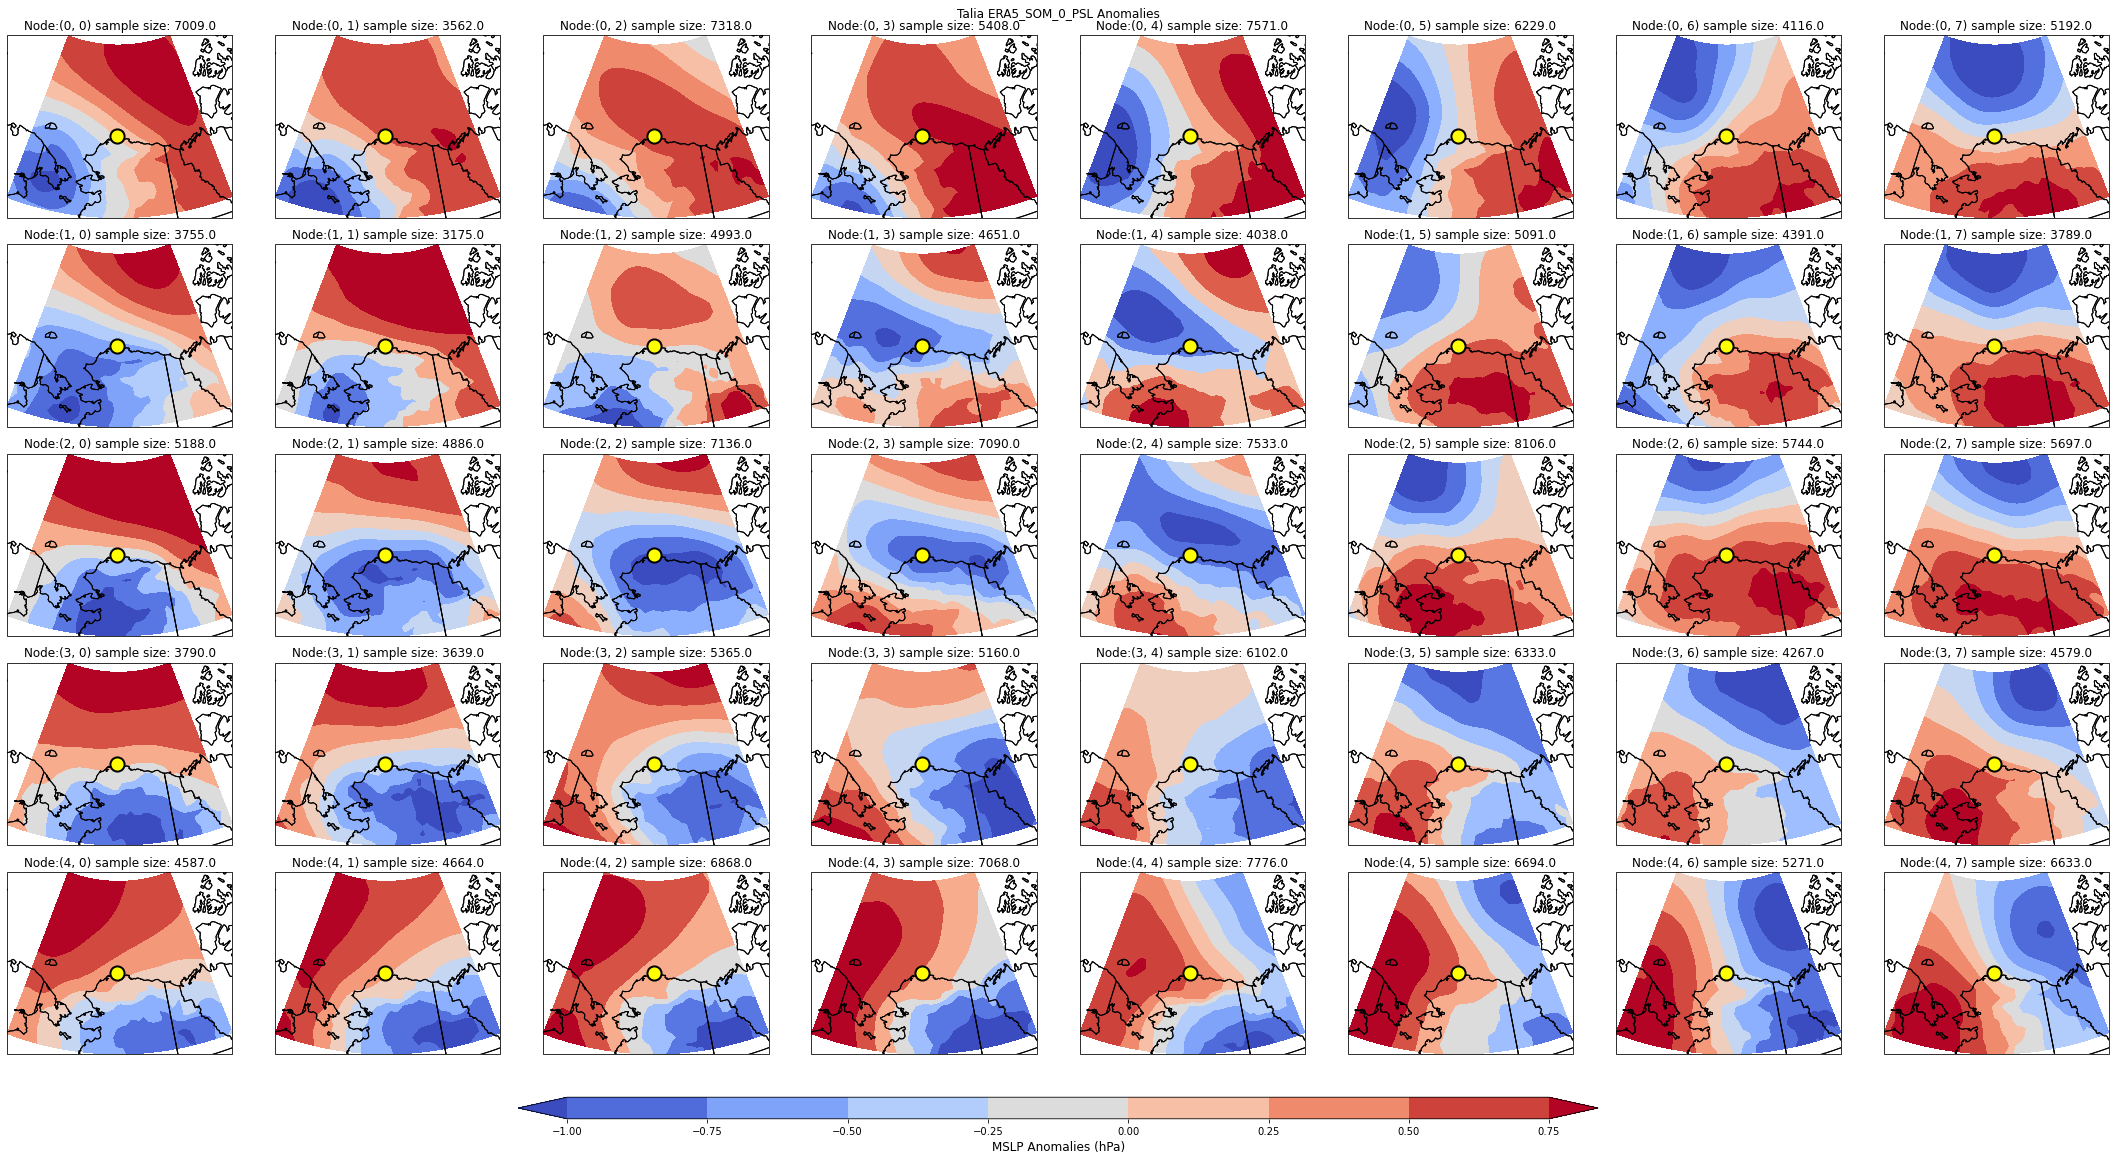

In [37]:
#Plot ERA5 SOM_4 MSLP anomalies using Maria's method

datacrs = ccrs.PlateCarree()

fig, axs = plt.subplots(5, 8, subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-156, central_latitude=71, standard_parallels=(30, 60))},
                        figsize=(30, 15),facecolor='white')  #width,height

for map_num in range(len(som_keys_era5)):
    temp_data = anom_01[np.array(winmap_era5[som_keys_era5[map_num]]),:,:].mean(['time'])
    node = som_keys_era5[map_num]
    cs2 = axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].contourf(lon, lat, temp_data, cmap='coolwarm',transform = ccrs.PlateCarree(),extend='both')
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].set_title('Node:' + str(node) + ' ' + f"sample size: {frequencies_era5.flatten()[map_num]}", fontsize=12)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].coastlines()
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.STATES)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.BORDERS)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].scatter(-156.36,71.19, c='yellow',marker= 'o',s=200, linewidth=2,edgecolors= "black" ,zorder= 4,transform=datacrs)


# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.02])    #x,y, dx, dy
cbar=fig.colorbar(cs2,cax=cbar_ax,orientation='horizontal')
cbar.set_label('MSLP Anomalies (hPa)', fontsize=12)
plt.suptitle('Talia ERA5_SOM_0_PSL Anomalies', fontsize = 12)

plt.tight_layout()
#plt.savefig('ERA5_SOM_4_PSL_ANOMS.png')
plt.show()

In [36]:
#Plot ERA5 SOM_0 MSLP raw values using Maria's method

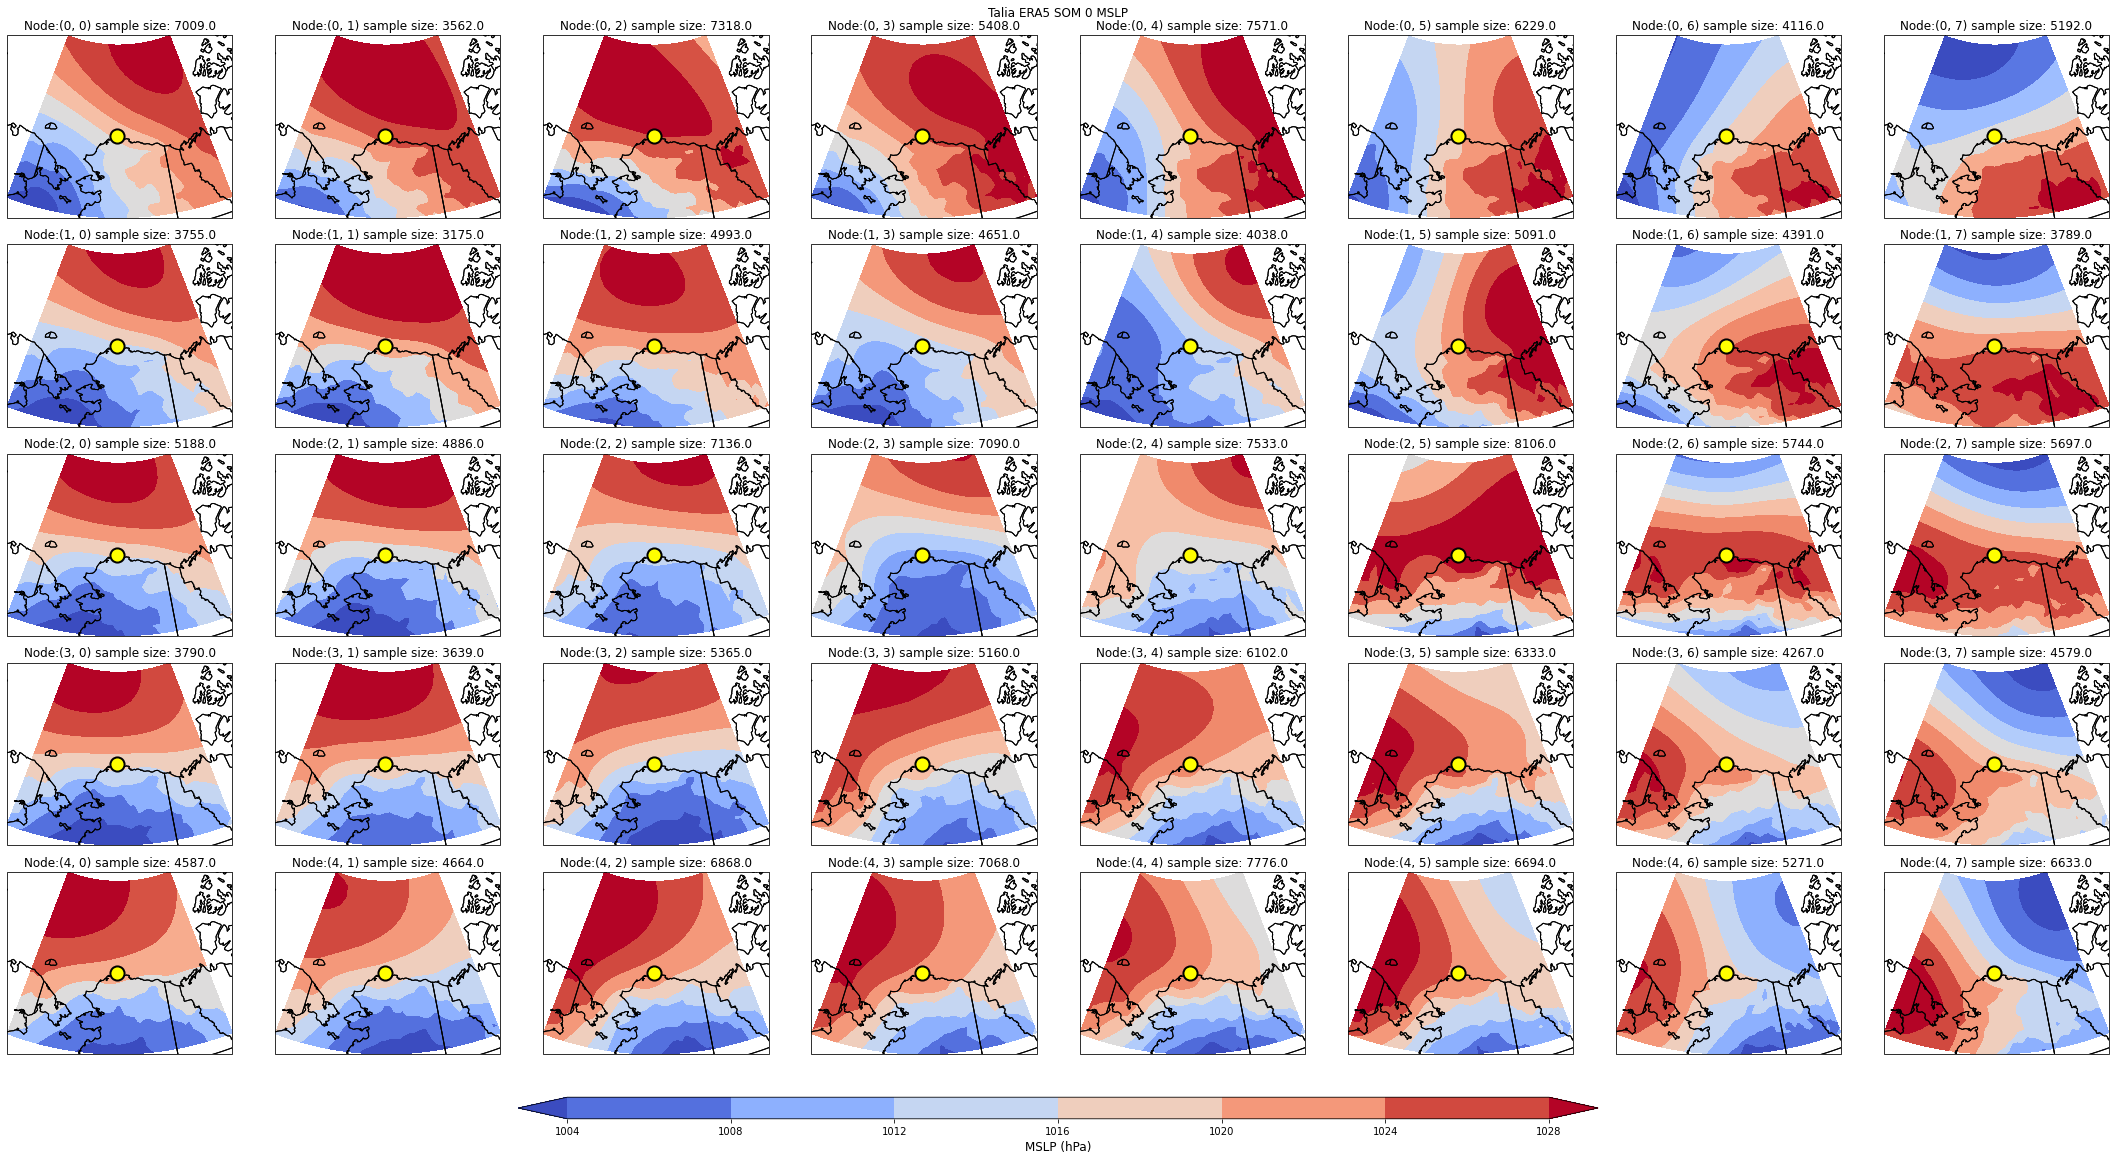

In [40]:
#Plot ERA5 SOM_0 MSLP raw values using Maria's method

datacrs = ccrs.PlateCarree()

fig, axs = plt.subplots(5, 8, subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-156, central_latitude=71, standard_parallels=(30, 60))},
                        figsize=(30, 15),facecolor='white')  #width,height

for map_num in range(len(som_keys_era5)):
    temp_data = mslpraw[np.array(winmap_era5[som_keys_era5[map_num]]),:,:].mean(['time'])
    node = som_keys_era5[map_num]
    cs2 = axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].contourf(lon, lat, temp_data, cmap='coolwarm',transform = ccrs.PlateCarree(),extend='both')
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].set_title('Node:' + str(node) + ' ' + f"sample size: {frequencies_era5.flatten()[map_num]}", fontsize=12)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].coastlines()
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.STATES)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.BORDERS)
    axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].scatter(-156.36,71.19, c='yellow',marker= 'o',s=200, linewidth=2,edgecolors= "black" ,zorder= 4,transform=datacrs)


# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.02])    #x,y, dx, dy
cbar=fig.colorbar(cs2,cax=cbar_ax,orientation='horizontal')
cbar.set_label('MSLP (hPa)', fontsize=12)
plt.suptitle('Talia ERA5 SOM 0 MSLP', fontsize = 12)

plt.tight_layout()
#plt.savefig('ERA5_SOM_4_PSL_ANOMS.png')
plt.show()

In [ ]:
#Train new SOM with Talia's data to get something to work

In [ ]:
#Below initializes a 4x6 SOM (10 SOMs, Sigma = 3.0, LR = 0.005) and then plots the frequency distribution, the sammon plot, and the MSLP anom plot

In [49]:
# initialize som object using the asymptotic decay function
x=6   #columns
y=4 #row

input_length = 1008

qerror_list = []
q_win = 100000.
for i in range(10):
    # initialize random weights
    era5_hourly_som1 = minisom.MiniSom(y,x, input_len = 1008, sigma = 3, learning_rate=0.005, neighborhood_function='bubble', decay_function = asymptotic_decay)
    era5_hourly_som1.random_weights_init(data_train)
    
    # train som
    era5_hourly_som1.train(data_train, num_iteration=100000, random_order=True, verbose=True)
    q_error = era5_hourly_som1.quantization_error(data_train)
    
    with open('/glade/work/tdolan/talia_som/som_'+str(i)+'.p', 'wb') as outfile: #this is how you save the file, the str(i) is a unique name
        pickle.dump(era5_hourly_som1, outfile)
    weights = era5_hourly_som1._weights
    qerror_list += [q_error]
    i+=1
    if q_error < q_win:
        q_win = q_error
        win_weights = era5_hourly_som1

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 125.4741958460748
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 125.3173772008733
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 125.28429899505139
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 125.18371018148105
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 125.00045997520367
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 125.31773707398547
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 125.5942976223422
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 125.40094923957028
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 125.6656883737816
 [  68890 / 100000 ]  69% - 0:00:04 left 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 125.09023052390454


In [ ]:
#Frequency and Sammon Plot

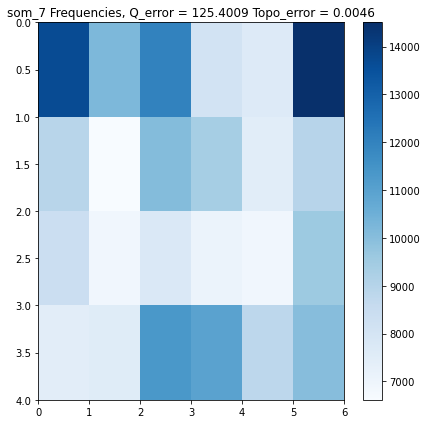

TolFun exceeded: Optimisation terminated


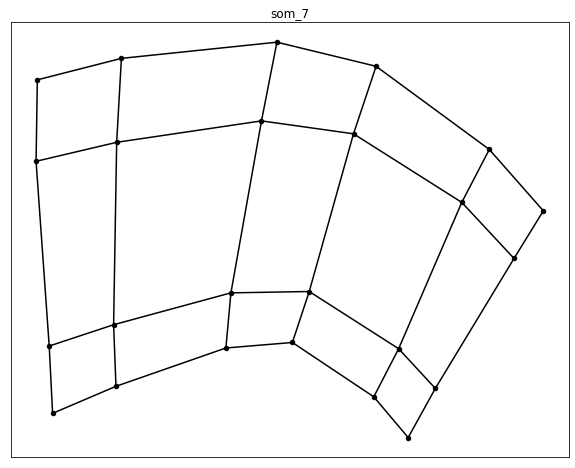

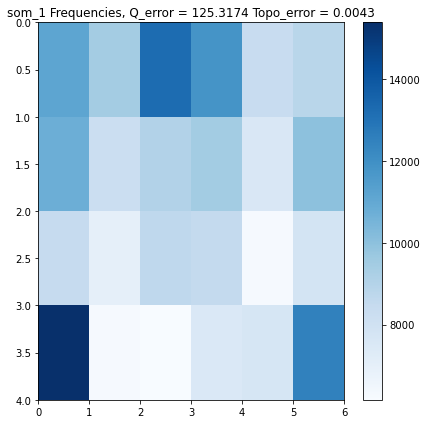

TolFun exceeded: Optimisation terminated


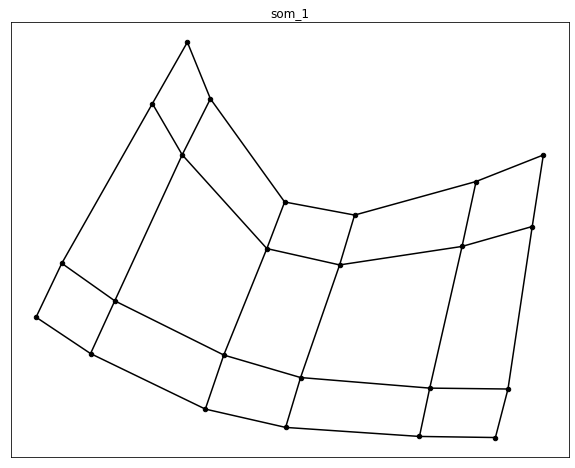

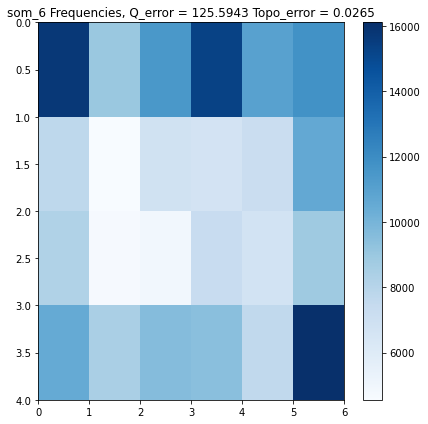

TolFun exceeded: Optimisation terminated


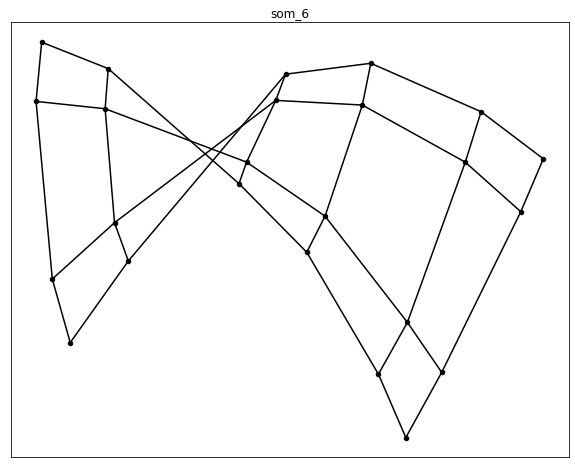

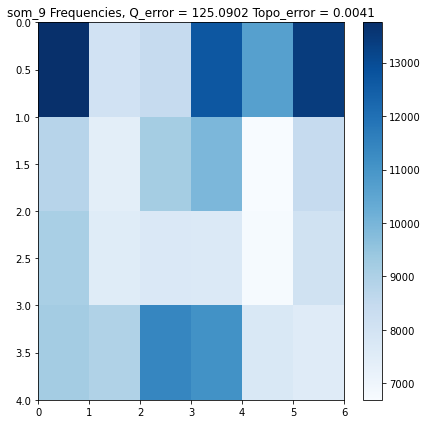

TolFun exceeded: Optimisation terminated


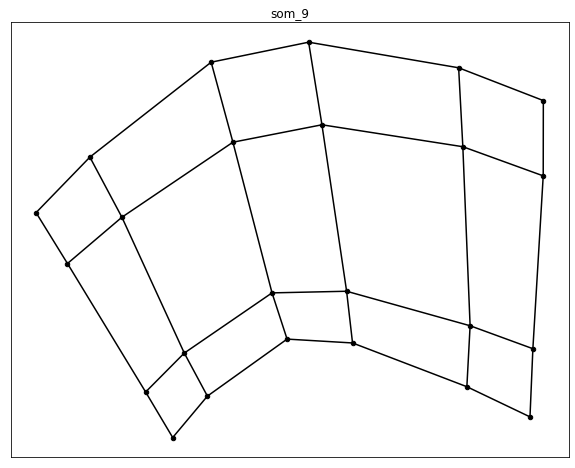

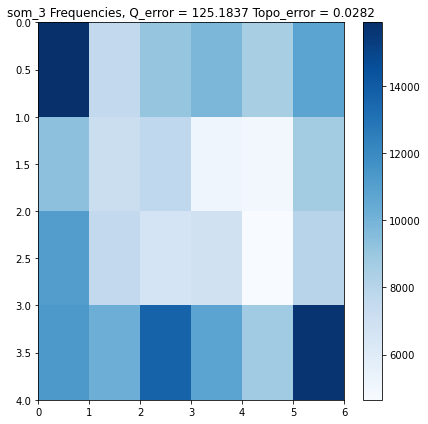

TolFun exceeded: Optimisation terminated


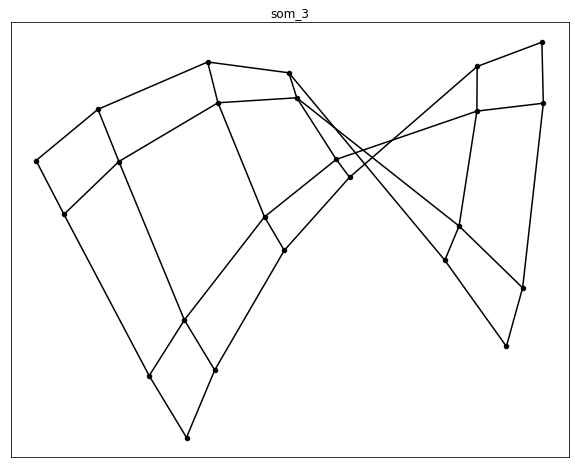

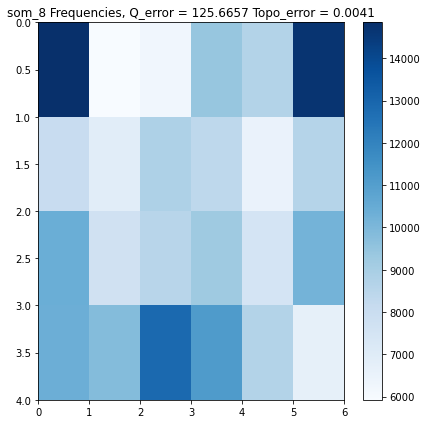

TolFun exceeded: Optimisation terminated


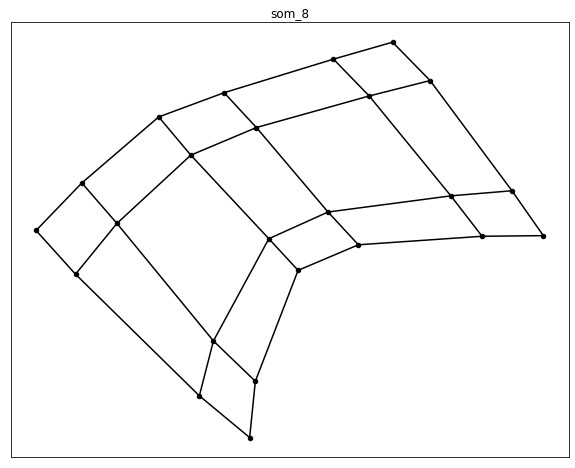

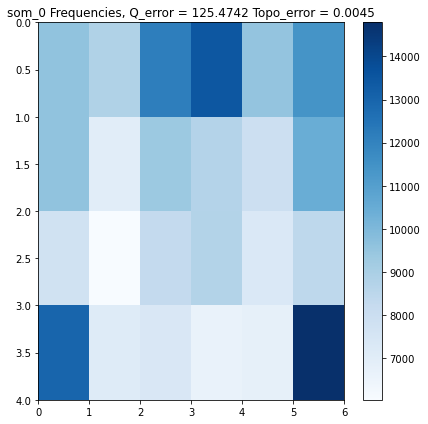

TolFun exceeded: Optimisation terminated


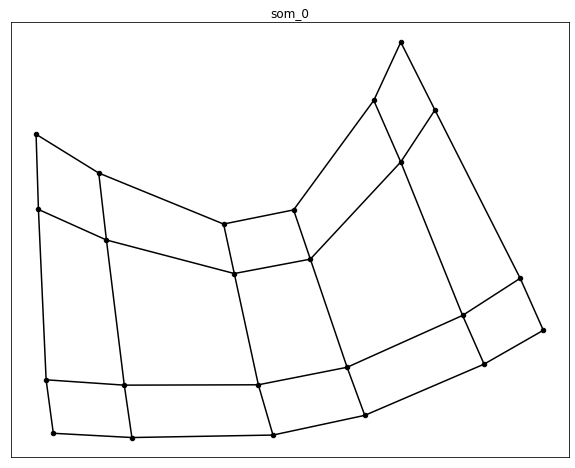

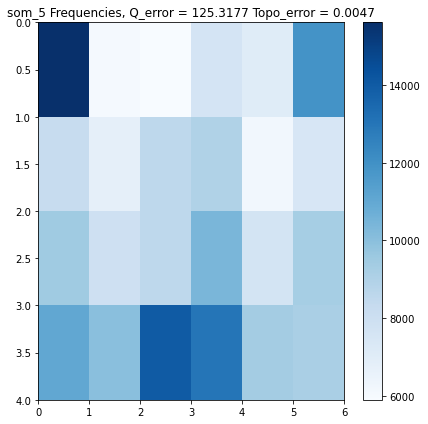

TolFun exceeded: Optimisation terminated


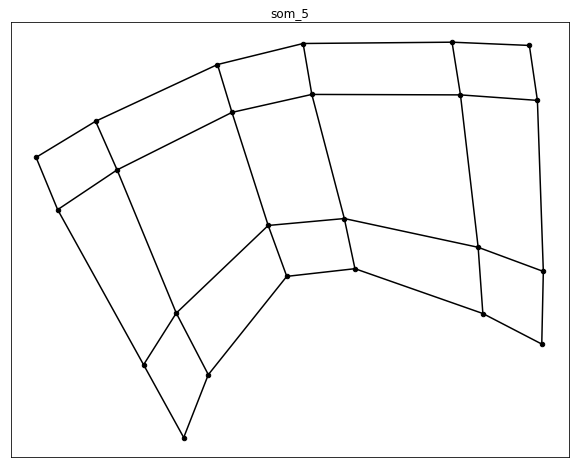

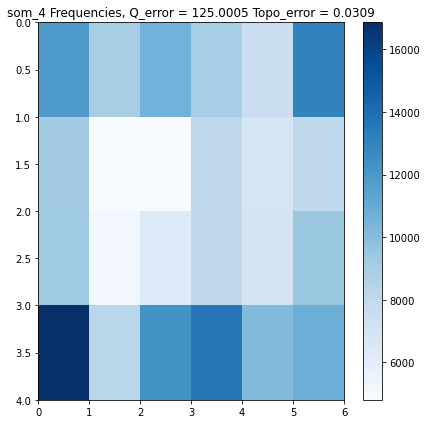

TolFun exceeded: Optimisation terminated


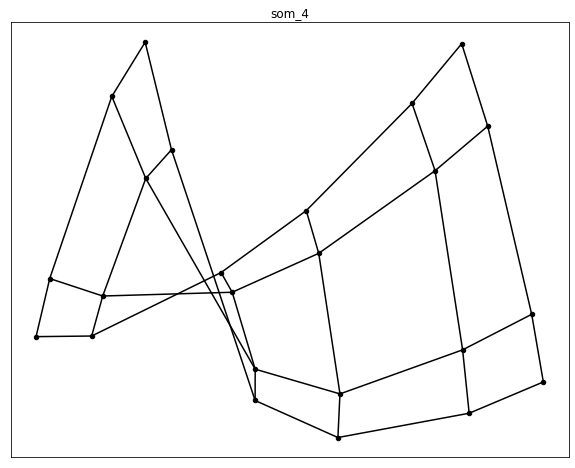

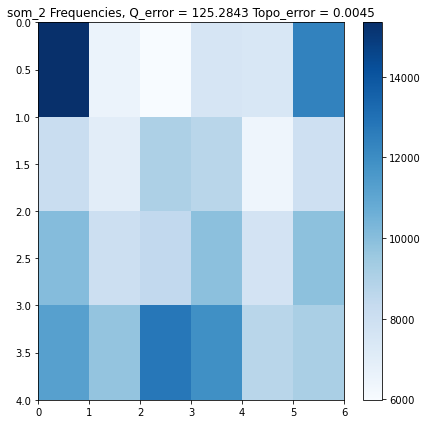

TolFun exceeded: Optimisation terminated


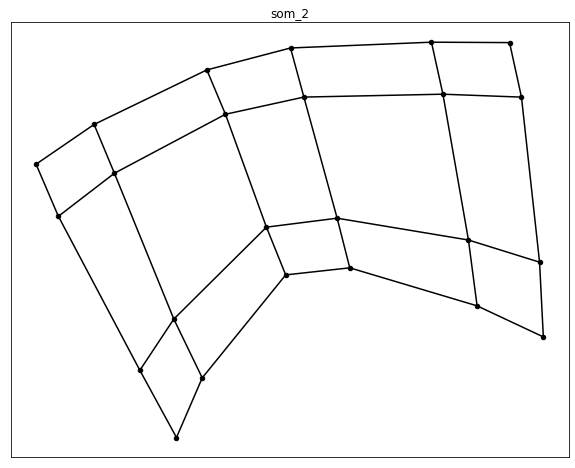

In [50]:
#Frequency and Sammon Plot
som_col = 6
som_row = 4
x_coor =6
y_coor= 4

input_length = 1008

mslp = mslpraw.values
folderpath = '/glade/work/tdolan/talia_som/'  #This is where all your SOMs were saved

names = ([os.path.splitext(os.path.split(x)[-1])[0] for x in glob.glob("/glade/work/tdolan/talia_som/som*.p")]) #this might be different for you

#but this is just grabbing the first few characters of my names of my file (see above how I named them, for example som_28

filepaths = glob.glob("/glade/work/tdolan/talia_som/som*.p") #this is showing the path and the given file

for path, name in zip(filepaths, names):
    with open (path, 'rb') as f:
        file = pickle.load(f) #This is loading every single som in that location
        frequencies = file.activation_response(data_train) #this is grabbing each freq
        q_error = round(file.quantization_error(data_train),4) #this is grabbing every q error out to 4 decimal places
        topo_error = round(file.topographic_error(data_train),4) #this is grabbing ever topographic error out to 4 decimal places
        plt.figure(figsize=(6,6))
        cs = plt.pcolormesh(frequencies, cmap='Blues')
        plt.title(name + ' ' + 'Frequencies,' + ' ' + 'Q_error =' + ' ' f"{q_error}" + ' ' + 'Topo_error =' + ' ' f"{topo_error}", fontsize=12)

        #in the title, I am plotting every q error and topo error from each som. You need to have the f" in front and whatever variable in {}
        #And this ' ' represents a space in the title
        plt.colorbar(cs)
        plt.ylim(4, 0) # Change the 4 to whatever size SOM you have (this is the 2nd number)
        plt.tight_layout()
        plt.savefig(folderpath + 'frequencies_'+name+'.png') #I am saving the outputs as a png file in the same file path and giving it the name of each SOM
        plt.show()
        
        [y,E] = sammon(file.get_weights().reshape(som_col*som_row, input_length),2,display=1)

            # Plot Sammon map nodes
        plt.figure(figsize=(10,8))
        plt.scatter(y[:,0], y[:,1], s=20, c='black', marker='o')

            # Add lines between nodes
        mslp = np.reshape(y,(som_row,som_col,2))
        len_x, len_y, len_z = mslp.shape

        # add vertical lines
        for i in range(len_x-1):
            for j in range(len_y):
                plt.plot(mslp[i:i+2,j,0],mslp[i:i+2,j,1],c='black')

        # add horizontal lines
        for i in range(len_x):
            for j in range(len_y-1):
                plt.plot(mslp[i,j:j+2,0],mslp[i,j:j+2,1],c='black')  

        plt.xticks([])
        plt.yticks([])
        plt.title(name, fontsize=12)
        #plt.savefig(folderpath + 'sammonplot_'+name+'.png') #I am saving the outputs as a png file in the same file path and giving it the name of each SOM

        plt.show()


In [37]:
#Anomaly Plot

In [ ]:
som_col = 6
som_row = 4

folderpath = '/glade/work/tdolan/talia_som/'  #This is where all your SOMs were saved

names = ([os.path.splitext(os.path.split(x)[-1])[0] for x in glob.glob("/glade/work/tdolan/talia_som/som*.p")]) #this might be different for you

#but this is just grabbing the first few characters of my names of my file (see above how I named them, for example som_28

filepaths = glob.glob("/glade/work/tdolan/talia_som/som*.p") #this is showing the path and the given file

for path, name in zip(filepaths, names):
    with open (path, 'rb') as f:
        file = pickle.load(f) #This is loading every single som in that location
        file_weights= file._weights
        nrows = file_weights.shape[0]
        ncols = file_weights.shape[1]

        fig, axs = plt.subplots(4, 6, subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-156, central_latitude=71, standard_parallels=(30, 60))},
                        figsize=(30, 15),facecolor='white')  
        fig.tight_layout()

        axs=axs.flatten()
        #vs=0+(np.arange(-1,1,0.25))

        for k in range(file_weights.shape[1]):
            for i in range(file_weights.shape[0]):
                mslp = file_weights[i,k,:].reshape(nx,ny)
                #print(mslp.max(),mslp.min())
                #levs=0+(np.arange(-10,10,2))
        
                node=(i+1)+k*file_weights.shape[0]
                cs2=axs[i+k*file_weights.shape[0]].contourf(lon, lat, mslp,
                            transform = ccrs.PlateCarree(),
                            cmap='coolwarm',extend='both')
    
                axs[i+k*file_weights.shape[0]].coastlines()
                axs[i+k*file_weights.shape[0]].add_feature(cfeature.BORDERS) 
                axs[i+k*file_weights.shape[0]].add_feature(cfeature.STATES)
                #axs[i+k*file_weights.shape[0]].scatter(-156.36,71.19, c='yellow',marker= 'o',s=200, linewidth=2,edgecolors= "black" ,zorder= 4,transform=datacrs)
        

        # Title each subplot 
                axs[i+k*file_weights.shape[0]].set_title('Node:'+str(node), fontsize=18)
     
        
        plt.tight_layout()
        fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.6,
                wspace=0.05, hspace=0.25)


# Add a colorbar axis at the bottom of the graph
        cbar_ax = fig.add_axes([0.08, 0.2, 0.5, 0.02])

        cbar=fig.colorbar(cs2,cax=cbar_ax,orientation='horizontal')

        cbar.set_label('MSLP Anomalies (hPa)', fontsize=22)

# Add a big title at the top
        plt.suptitle(name + ' ' + 'Talia SOM Nodes 6 by 4 LR=0.005 [Asymptotic Decay Method].', x= 0.33 ,fontsize=22)
        #plt.savefig(folderpath + 'SOM_plot'+name+'.png')
        plt.show()

In [ ]:
#Create a dictionary for all of the SOMS

folderpath = '/glade/work/tdolan/talia_som/'  #This is where all your SOMs were saved

names = ([os.path.splitext(os.path.split(x)[-1])[0] for x in glob.glob("/glade/work/tdolan/talia_som/som*.p")]) #this might be different for you

filepaths = glob.glob("/glade/work/tdolan/talia_som/som*.p") #this is showing the path and the given file
    
keys_era5 = [i for i in product(range(4), range(6))]
winmap_era5 = {key: [] for key in keys_era5}

for path, name in zip(filepaths, names):
    with open (path, 'rb') as f:
        file = pickle.load(f)
        for i, x in enumerate(data_train):
            winmap_era5[file.winner(x)].append(i)
        som_keys_era5 = getList(winmap_era5)
            frequencies_era5 = file.activation_response(data_train)


KeyboardInterrupt



In [ ]:
#Plotting the mslp raw data for all the SOMs
som_col = 6
som_row = 4

datacrs = ccrs.PlateCarree()

for path, name in zip(filepaths, names):
    with open (path, 'rb') as f:
        file = pickle.load(f)
        fig, axs = plt.subplots(4, 6, subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-156, central_latitude=71, standard_parallels=(30, 60))},
                        figsize=(30, 15),facecolor='white')  #width,height
    
            for map_num in range(len(som_keys_era5)):
                temp_data = mslpraw[np.array(winmap_era5[som_keys_era5[map_num]]),:,:].mean(['time'])
                node = som_keys_era5[map_num]
                cs2 = axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].contourf(lon, lat, temp_data, cmap='coolwarm',transform = ccrs.PlateCarree(),extend='both')
                axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].set_title('Node:' + str(node) + ' ' + f"sample size: {frequencies_era5.flatten()[map_num]}", fontsize=12)
                axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].coastlines()
                axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.STATES)
                axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].add_feature(cfeature.BORDERS)
                axs[som_keys_era5[map_num][0],som_keys_era5[map_num][1]].scatter(-156.36,71.19, c='yellow',marker= 'o',s=200, linewidth=2,edgecolors= "black" ,zorder= 4,transform=datacrs)

         # Add a colorbar axis at the bottom of the graph
        cbar_ax = fig.add_axes([0.25, -0.05, 0.5, 0.02])    #x,y, dx, dy
        cbar=fig.colorbar(cs2,cax=cbar_ax,orientation='horizontal')
        cbar.set_label('MSLP (hPa)', fontsize=12)
        plt.suptitle('Talia ERA5 SOMs (4x6) MSLP', fontsize = 12)
        plt.tight_layout()
        #plt.savefig('ERA5_SOM_4_PSL_ANOMS.png')
        plt.show()